# <center> `Library Importing and config class`  </center>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os, numpy as np, pandas as pd
from sklearn.model_selection import train_test_split


from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, SpatialDropout1D

from keras.layers import MaxPool1D, Flatten, Conv1D, GRU, GlobalAveragePooling1D, GlobalMaxPooling1D,concatenate,Bidirectional, GlobalMaxPool1D

from keras.callbacks import ReduceLROnPlateau, EarlyStopping

from keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam
from keras import initializers,optimizers, layers
from keras.initializers import Constant


In [2]:
class config_class(object):
    def __init__(self, max_features, maxlen,embed_size,batch_size,epochs):
        self.max_features = max_features
        self.maxlen = maxlen
        self.embed_size = embed_size
        self.batch_size = batch_size
        self.epochs = epochs
        
config=config_class(max_features = 20000, maxlen = 200, embed_size = 50,batch_size = 64,epochs = 128)

# <center> `Data importing and preperation`  </center>

In [3]:
train = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip')
test  = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip')

In [4]:
classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
Train_y = train[classes].values
Train_x = train["comment_text"]
Test_x  = test["comment_text"]


# <center> `Tokenization and padding`  </center>

In [5]:
tokenizer =Tokenizer(num_words=config.max_features,
                     filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', 
                     split=' ', oov_token='<OOV>')
tokenizer.fit_on_texts(list(Train_x))

Train_x_tokenized = tokenizer.texts_to_sequences(Train_x)
Test_x_tokenized  = tokenizer.texts_to_sequences(Test_x)

In [6]:
Train_x_tokenized_padded = pad_sequences(Train_x_tokenized, maxlen=config.maxlen , padding='post',truncating='post')
Test_x_tokenized_padded  = pad_sequences(Test_x_tokenized , maxlen=config.maxlen , padding='post',truncating='post')

In [7]:
X_train, X_val, Y_train, Y_val = train_test_split( Train_x_tokenized_padded, Train_y, test_size=0.33, random_state=42)

# <center> `Glove50 Embeddings vector`  </center>

In [8]:
def get_coefs(word,*arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open('/kaggle/input/glove6b50dtxt/glove.6B.50d.txt')) 

all_embs = np.stack(embeddings_index.values()) 
emb_mean,emb_std = all_embs.mean(), all_embs.std() 


word_index = tokenizer.word_index 
nb_words = min(config.max_features, len(word_index)) 
                                              
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, config.embed_size))



for word, i in word_index.items():
    if i >= config.max_features: 
        continue 
    embedding_vector = embeddings_index.get(word) 
    
    if embedding_vector is not None: 
        embedding_matrix[i] = embedding_vector 
        
        

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3377: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


# <center> `Model Initialization and Compiling`  </center>

In [9]:
model = Sequential([
    Input(shape=(config.maxlen,)),
    Embedding(config.max_features, config.embed_size, trainable=False,embeddings_initializer=Constant(embedding_matrix)),
    SpatialDropout1D(0.2),
    Bidirectional(GRU(128, return_sequences=True, dropout=0.1)),
    Bidirectional(GRU(128, return_sequences=True, dropout=0.1)),
    GlobalMaxPool1D(),
    Dropout(0.1),
    Dense(100, activation="relu"),
    Dropout(0.1),
    Dense(50, activation="relu"),
    Dropout(0.1),
    Dense(6, activation="sigmoid")
    ])
optimizer= Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
model.summary()

2022-04-09 19:01:02.995077: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-09 19:01:03.086781: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-09 19:01:03.087608: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-09 19:01:03.088874: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 50)           1000000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 200, 50)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 200, 256)          138240    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200, 256)          296448    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               2

In [10]:
reduce_LR = ReduceLROnPlateau(monitor='val_loss',patience=2, verbose=1, factor=0.5, min_lr=0.00000001)
early_stopping = EarlyStopping(monitor='val_loss', patience=15,restore_best_weights=True)

weights_file = 'autoencoder_denoising.h5'
if os.path.exists(weights_file):
    model.load_weights(weights_file)
    my_history=np.load('my_history.npy',allow_pickle='TRUE').item()
    print('Loaded weights!')
    
else:
    history_keras =  model.fit(X_train, Y_train,batch_size=config.batch_size, epochs=config.epochs, validation_data=(X_val, Y_val), callbacks=[early_stopping,reduce_LR])
    model.save_weights('autoencoder_denoising.h5')
    np.save('my_history.npy',history_keras.history)
    my_history=history_keras.history



2022-04-09 19:01:06.835552: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/128


2022-04-09 19:01:12.588415: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1671/1671 [==============================] - 106s 59ms/step - loss: 0.1077 - accuracy: 0.7209 - val_loss: 0.0651 - val_accuracy: 0.9940
Epoch 2/128
1671/1671 [==============================] - 93s 56ms/step - loss: 0.0714 - accuracy: 0.8419 - val_loss: 0.0616 - val_accuracy: 0.9941
Epoch 3/128
1671/1671 [==============================] - 93s 55ms/step - loss: 0.0673 - accuracy: 0.8932 - val_loss: 0.0580 - val_accuracy: 0.9941
Epoch 4/128
1671/1671 [==============================] - 93s 56ms/step - loss: 0.0641 - accuracy: 0.9235 - val_loss: 0.0561 - val_accuracy: 0.9940
Epoch 5/128
1671/1671 [==============================] - 94s 56ms/step - loss: 0.0620 - accuracy: 0.9415 - val_loss: 0.0553 - val_accuracy: 0.9939
Epoch 6/128
1671/1671 [==============================] - 94s 56ms/step - loss: 0.0603 - accuracy: 0.9625 - val_loss: 0.0536 - val_accuracy: 0.9940
Epoch 7/128
1671/1671 [==============================] - 93s 56ms/step - loss: 0.0586 - accuracy: 0.9692 - val_loss: 0.0524 - val

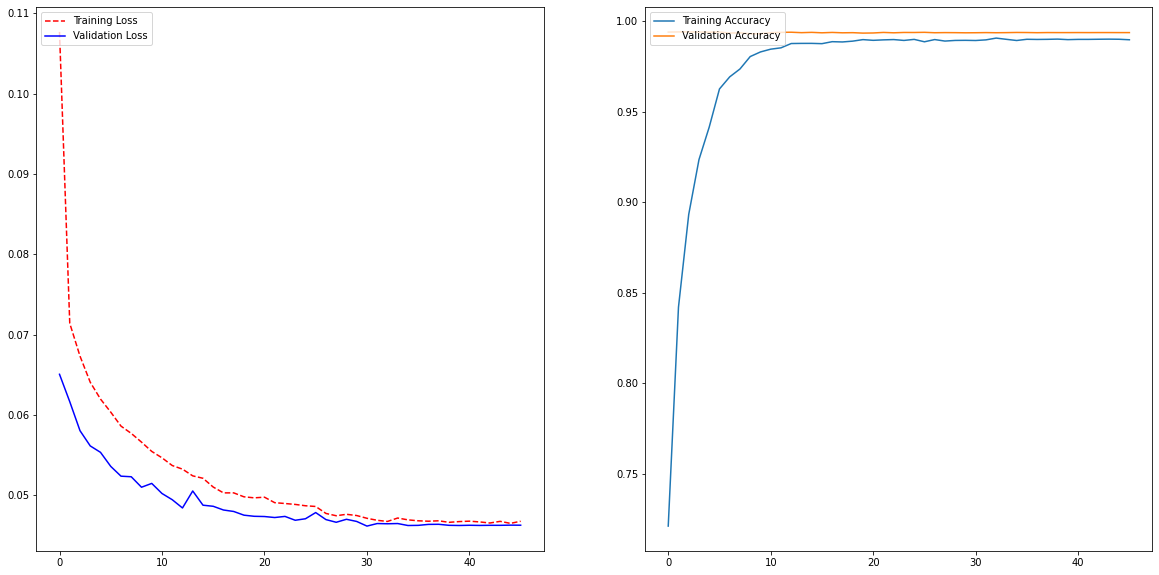

In [11]:

f, axarr = plt.subplots(1,2) 
plt.gcf().set_size_inches(20, 10)

axarr[0].plot(my_history['loss'], 'r--')
axarr[0].plot(my_history['val_loss'], 'b-')
axarr[0].legend(['Training Loss', 'Validation Loss'], loc = 'upper left')

axarr[1].plot(my_history['accuracy'])
axarr[1].plot(my_history['val_accuracy'])
axarr[1].legend(['Training Accuracy', 'Validation Accuracy'], loc = 'upper left')


plt.show()

In [12]:
y_test = model.predict([Test_x_tokenized_padded], batch_size=1024, verbose=1) 
sample_submission = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip')
sample_submission[classes] = y_test 
sample_submission.to_csv('submission.csv', index=False) 

150/150 [==============================] - 13s 75ms/step
